# Visualizing Feature Maps using PyTorch

## References:
1. https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
2. https://github.com/arshren/Feature-Visualization

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
from CNNmodel import ConvNet
# changes circles to non-square
from ShapeData import train_loader, valid_loader
import matplotlib.cm as cm

In [2]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.),
    transforms.Grayscale()
])

In [1]:
'''
model = models.resnet18(pretrained=True)
print(model)
'''

# to restore:
model = ConvNet()

model.load_state_dict(torch.load("..\\square_classifier"))

# print loss
criterion = torch.nn.CrossEntropyLoss()
model.eval()
avg_loss = 0
for x, y in valid_loader:
    output = model(x)
    loss = criterion(output.squeeze(1), y.to(torch.float32))
    avg_loss += loss.item()
avg_loss /= len(valid_loader)
print("avg_loss", avg_loss)
print(model)

NameError: name 'ConvNet' is not defined

In [4]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    
# get names of conv_layers
names = []
for layer in conv_layers[0:]:
    names.append(str(layer))
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 3
conv_layers


In [5]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([3, 3, 1, 12])
12


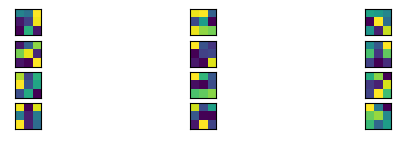

Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([3, 3, 12, 20])
20


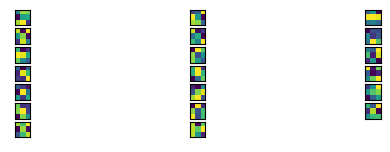

Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([3, 3, 20, 32])
32


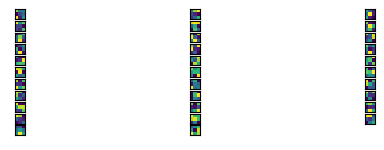

In [28]:
# plot filters
for layer in conv_layers[0:]:
    weights, bias= layer.weight.T, layer.bias.T
    print(str(layer), weights.shape)
     #normalize filter values between  0 and 1 for visualization
    f_min, f_max = weights.min(), weights.max()
    filters = (weights - f_min) / (f_max - f_min)  
    print(weights.shape[3])
    filter_cnt=1
    #plotting all the filters
    for i in range(filters.shape[3]):
    #for i in range(6):
        #get the filters
        filt=filters[:,:,:, i].detach()
        #plotting ecah channel
        #plt.figure( figsize=() )
        #f = plt.figure(figsize=())
        ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filt[:,:, 0])
#         plt.imshow(filt[:,:, 0], cmap=cm.gray, vmin=0, vmax=255)
        filter_cnt+=1
    plt.show()

In [7]:
def feature_maps(image):
    '''
    Takes in PIL image
    '''
    # Apply transformation on the image, Add the batch size, and load on GPU
    image = transform(image)
#     print(f"Image shape before: {image.shape}")
    image = image.unsqueeze(0)
#     print(f"Image shape after: {image.shape}")
    image = image.to(device)
    
#     print(image.shape)
    outputs = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
#     print(len(outputs))

    processed = [feature_map.T for feature_map in outputs] # TODO: apply the activation
    
    return processed

In [16]:
# plot feature maps
def plot_feature_maps_pytorch(processed):
    for layer_name, feature_map in zip(names, processed):
#       print(feature_map.shape)
      if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-2]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
          x  = feature_map[:, :, i, 0].detach().numpy()
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap=cm.gray, vmin=0, vmax=255) 

torch.Size([200, 200, 12, 1])


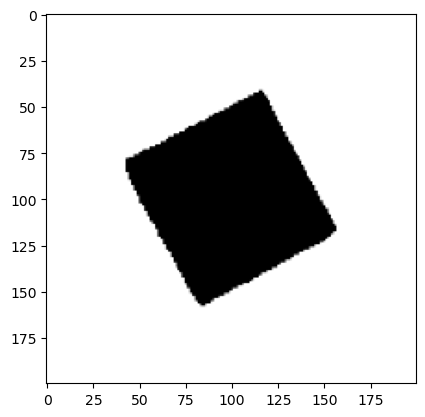

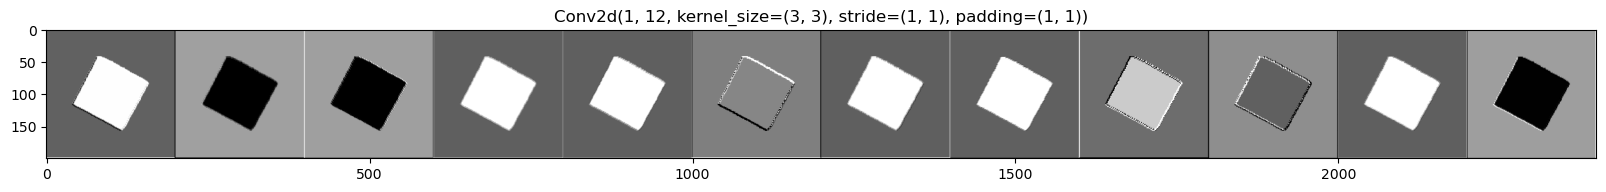

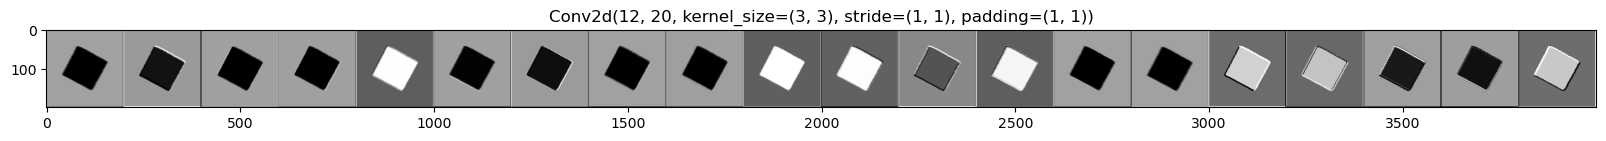

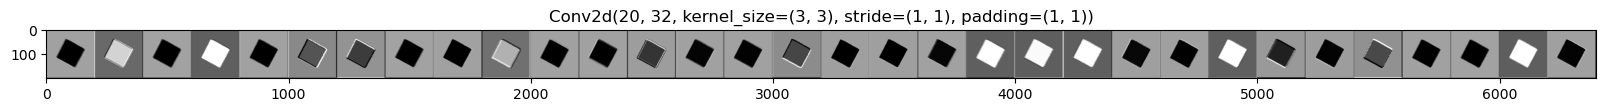

In [17]:
image = Image.open(str('archive (4)/shapes/square/126.png'))
plt.imshow(image, cmap=cm.gray, vmin=0, vmax=255)

processed = feature_maps(image)
print(processed[0].shape)
plot_feature_maps_pytorch(processed)

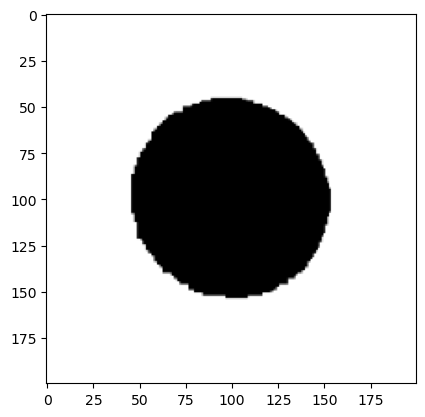

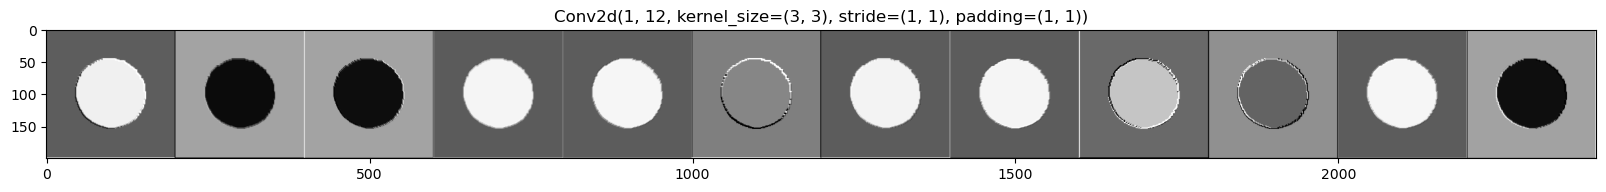

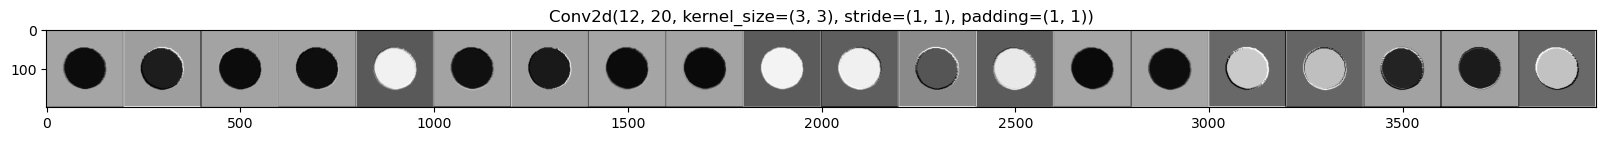

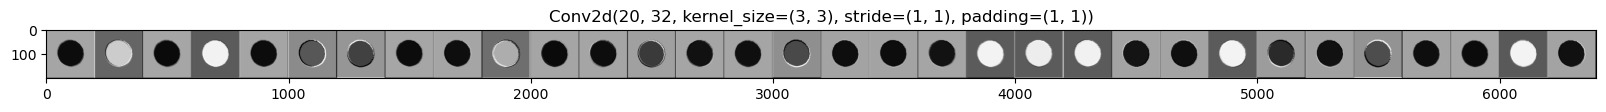

In [26]:
image = Image.open(str('archive (4)/shapes/non-square/126.png'))
plt.imshow(image, cmap=cm.gray, vmin=0, vmax=255)
processed = feature_maps(image)
plot_feature_maps_pytorch(processed)